# Mood Classification of Spotify Songs with Machine Learning
**Author:** Juan Antonio Robledo ([GitHub](https://github.com/JuanRobledo12))

### Description
This notebook leverages a labeled dataset of songs, categorized by mood, to train a machine learning classifier. The goal is to apply this model to a larger, unlabeled dataset, effectively categorizing each song by its mood.

Key steps in our process include:
- Cleaning `main_dataset.csv` to ensure it matches the structure of our labeled dataset.
- Evaluating various classification models, including Random Forest, Logistic Regression, SVMs, and XGBoost, followed by hyperparameter tuning to optimize performance.
- Using the best-performing model to label the larger dataset, resulting in a comprehensive mood-labeled song dataset comprising approximately 300,000 entries.

### Findings
- After tuning, XGBoost and Random Forest emerged as the most effective models. We opted to use XGBoost for the final labeling task.
- Implementing SMOTE for oversampling significantly improved model performance, helping to counteract the effects of an imbalanced dataset.

### Generating the Labeled Dataset
- Execute all notebook cells to label the dataset using the pre-tuned XGBoost classifier. If you prefer to use Random Forest instead, refer to section 4.3.
- The notebook's final cell exports the labeled dataset to a CSV file, ready for further analysis or application.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

## 1. Review of datasets

Here we check the data inside the main_dataset which is not labeled with moods. In addition, we check the training dataset with labels ('complete_modds_dataset').

In [2]:
df_main = pd.read_csv('DATA/main_dataset.csv')
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277938 entries, 0 to 277937
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   track_uri             277938 non-null  object 
 1   name                  277923 non-null  object 
 2   artists_names         277938 non-null  object 
 3   popularity            277938 non-null  int64  
 4   album_type            277938 non-null  object 
 5   is_playable           277938 non-null  bool   
 6   release_date          277938 non-null  object 
 7   artists_uris          277938 non-null  object 
 8   playlist_uris         277938 non-null  object 
 9   danceability          277938 non-null  float64
 10  energy                277938 non-null  float64
 11  key                   277938 non-null  float64
 12  loudness              277938 non-null  float64
 13  mode                  277938 non-null  float64
 14  speechiness           277938 non-null  float64
 15  

In [3]:
df_moods = pd.read_csv('DATA/complete_moods_data.csv')
print(df_moods.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2293 non-null   object 
 1   artist            2293 non-null   object 
 2   id                2293 non-null   object 
 3   length            2293 non-null   int64  
 4   danceability      2293 non-null   float64
 5   acousticness      2293 non-null   float64
 6   energy            2293 non-null   float64
 7   instrumentalness  2293 non-null   float64
 8   liveness          2293 non-null   float64
 9   valence           2293 non-null   float64
 10  loudness          2293 non-null   float64
 11  speechiness       2293 non-null   float64
 12  tempo             2293 non-null   float64
 13  time_signature    2293 non-null   int64  
 14  mood              2293 non-null   object 
dtypes: float64(9), int64(2), object(4)
memory usage: 268.8+ KB
None


### 1.1 Check common features between datasets

The only common feature that has a difference between the datasets is 'time_signature'. In df_main is float and in df_moods is int.

TODO: 
* ~~Convert 'time_signature' in df_main to int64~~

In [4]:
# Get lists of columns
columns_df_moods = set(df_moods.columns)
columns_df_main = set(df_main.columns)

# Find common columns
common_columns = columns_df_moods.intersection(columns_df_main)

# Find unique columns
unique_to_df_moods = columns_df_moods.difference(columns_df_main)
unique_to_df_main = columns_df_main.difference(columns_df_moods)

# Print results
print("Common columns:", common_columns)
print("Columns unique to df_moods:", unique_to_df_moods)
print("Columns unique to df_main:", unique_to_df_main)

Common columns: {'name', 'danceability', 'liveness', 'instrumentalness', 'speechiness', 'loudness', 'energy', 'time_signature', 'tempo', 'acousticness', 'valence'}
Columns unique to df_moods: {'mood', 'id', 'length', 'artist'}
Columns unique to df_main: {'duration_ms', 'popularity', 'artists_names', 'is_playable', 'artists_uris', 'artists_genres', 'artists_followers', 'release_date', 'mode', 'playlist_uris', 'album_type', 'track_uri', 'key', 'analysis_url', 'artists_popularities'}


In [5]:
df_main[['time_signature', 'instrumentalness', 'loudness', 'valence', 'liveness', 'danceability', 'name', 'speechiness', 'acousticness', 'tempo', 'energy']].head()

,time_signature,instrumentalness,loudness,valence,liveness,danceability,name,speechiness,acousticness,tempo,energy
0,4.0,0.000794,-8.815,0.520,0.7530,0.611,Way Up (feat. Ava Re),0.0672,0.0169,128.050,0.614
1,4.0,0.009530,-6.848,0.250,0.3490,0.638,Fantasy - Felix Jaehn Remix,0.0285,0.0118,122.985,0.781
2,4.0,0.000008,-8.029,0.247,0.2410,0.560,Try Me,0.0872,0.0071,170.044,0.810
3,4.0,0.000088,-4.571,0.199,0.0888,0.525,Walk on by (Sound Remedy Remix),0.0353,0.0178,92.011,0.699
4,4.0,0.000001,-5.863,0.163,0.0965,0.367,Pretty Wings,0.1060,0.3650,115.917,0.771


In [6]:
df_moods[['time_signature', 'instrumentalness', 'loudness', 'valence', 'liveness', 'danceability', 'name', 'speechiness', 'acousticness', 'tempo', 'energy']].head()

,time_signature,instrumentalness,loudness,valence,liveness,danceability,name,speechiness,acousticness,tempo,energy
0,4,0.000000,-8.201,0.625,0.0843,0.866,1999,0.0767,0.13700,118.523,0.730
1,4,0.196000,-5.069,0.166,0.1530,0.381,23,0.0492,0.01890,120.255,0.832
2,4,0.000077,-15.326,0.116,0.0934,0.346,9 Crimes,0.0321,0.91300,136.168,0.139
3,4,0.000006,-12.858,0.587,0.1130,0.466,99 Luftballons,0.0608,0.08900,193.100,0.438
4,4,0.000000,-3.604,0.445,0.1370,0.419,A Boy Brushed Red Living In Black And White,0.1060,0.00171,169.881,0.932


In [7]:
df_main[['time_signature', 'instrumentalness', 'loudness', 'valence', 'liveness', 'danceability', 'name', 'speechiness', 'acousticness', 'tempo', 'energy']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277938 entries, 0 to 277937
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time_signature    277938 non-null  float64
 1   instrumentalness  277938 non-null  float64
 2   loudness          277938 non-null  float64
 3   valence           277938 non-null  float64
 4   liveness          277938 non-null  float64
 5   danceability      277938 non-null  float64
 6   name              277923 non-null  object 
 7   speechiness       277938 non-null  float64
 8   acousticness      277938 non-null  float64
 9   tempo             277938 non-null  float64
 10  energy            277938 non-null  float64
dtypes: float64(10), object(1)
memory usage: 23.3+ MB


In [8]:
df_moods[['time_signature', 'instrumentalness', 'loudness', 'valence', 'liveness', 'danceability', 'name', 'speechiness', 'acousticness', 'tempo', 'energy']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time_signature    2293 non-null   int64  
 1   instrumentalness  2293 non-null   float64
 2   loudness          2293 non-null   float64
 3   valence           2293 non-null   float64
 4   liveness          2293 non-null   float64
 5   danceability      2293 non-null   float64
 6   name              2293 non-null   object 
 7   speechiness       2293 non-null   float64
 8   acousticness      2293 non-null   float64
 9   tempo             2293 non-null   float64
 10  energy            2293 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 197.2+ KB


### 1.2 Check the features that are different between the dataframes

* There are features that are the same in both dataframes but they have a different name:

| df_main     | df_moods     |
|-------------|--------------|
| track_uri   | id           |
| duration_ms | length       |
| artists_names   | artists  |


* In df_main the features like artist_names or popularities come in lists since we have multiple artists and playlists per song so we might want to reduce this to the main artist only to get rid of the lists.
* Artist and playlist uris have a prefix 'spotify:artist' and 'spotify:playlist'. We might want to remove those if we are using the uris.

TODO:
* ~~Rename the features in df_main so they match the ones from df_moods.~~
* ~~Make sure the 'duration_ms' is in int64 instead of float.~~
* ~~Create a new df_main dataframe where we drop the features that are irrelevant for the labeling. These features are the ones that aren't shared between df_main and df_moods.~~
* ~~Make sure the new dataset has the same column order like the original one.~~





In [9]:
df_main[['artists_uris', 'playlist_uris', 'artists_names', 'release_date', 'artists_genres', 'duration_ms', 'key', 'album_type', 'is_playable', 'analysis_url', 'artists_popularities', 'mode', 'track_uri', 'popularity', 'artists_followers']].head()

,artists_uris,playlist_uris,artists_names,release_date,artists_genres,duration_ms,key,album_type,is_playable,analysis_url,artists_popularities,mode,track_uri,popularity,artists_followers
0,['spotify:artist:4B7SI5PsnEgeMQd6gSIrbn'],['spotify:playlist:5JJZvA3VR9RZ5XIr0reWiM'],['Floduxe'],2015-11-20,[[]],195000.0,5.0,single,True,https://api.spotify.com/v1/audio-analysis/3v6s...,[9],0.0,spotify:track:3v6sBj3swihU8pXQQHhDZo,0,[765]
1,"['spotify:artist:6hfwwpXqZPRC9CsKI7qtv1', 'spo...",['spotify:playlist:5JJZvA3VR9RZ5XIr0reWiM'],"['Alina Baraz', 'Galimatias']",2015-09-04,"[['etherpop', 'pop', 'r&b'], ['chillstep', 'fu...",194641.0,4.0,album,True,https://api.spotify.com/v1/audio-analysis/7KCW...,"[68, 56]",0.0,spotify:track:7KCWmFdw0TzoJbKtqRRzJO,33,"[1283665, 138396]"
2,['spotify:artist:7kFfY4UjNdNyaeUgLIEbIF'],['spotify:playlist:5JJZvA3VR9RZ5XIr0reWiM'],['DeJ Loaf'],2014-10-15,"[['detroit hip hop', 'pop r&b', 'r&b', 'trap',...",217573.0,0.0,single,True,https://api.spotify.com/v1/audio-analysis/2CY9...,[65],0.0,spotify:track:2CY92qejUrhyPUASawNVRr,52,[1544981]
3,['spotify:artist:2F8tffsSfw1767WgjtAHBW'],['spotify:playlist:5JJZvA3VR9RZ5XIr0reWiM'],['Noosa'],2014-07-10,"[['shimmer pop', 'shiver pop']]",443478.0,9.0,single,True,https://api.spotify.com/v1/audio-analysis/11BP...,[32],1.0,spotify:track:11BPfwVbB7vok7KfjBeW4k,0,[18241]
4,"['spotify:artist:0B8XBGloduGCBtRK8nm2YF', 'spo...",['spotify:playlist:5JJZvA3VR9RZ5XIr0reWiM'],"['Zak Waters', 'Pretty Sister']",2014-06-17,"[['indie poptimism'], ['la pop']]",225862.0,9.0,single,True,https://api.spotify.com/v1/audio-analysis/3yUJ...,"[30, 39]",1.0,spotify:track:3yUJKPsjvThlcQWTS9ttYx,0,"[10105, 13775]"


In [10]:
df_moods[['id', 'length', 'artist', 'mood']].head()

,id,length,artist,mood
0,2H7PHVdQ3mXqEHXcvclTB0,379266,Prince,happy
1,4HIwL9ii9CcXpTOTzMq0MP,318800,Blonde Redhead,sad
2,5GZEeowhvSieFDiR8fQ2im,217946,Damien Rice,sad
3,6HA97v4wEGQ5TUClRM0XLc,233000,Nena,happy
4,47IWLfIKOKhFnz1FUEUIkE,268000,Underoath,energetic


In [11]:
df_moods['length'].info()
df_main['duration_ms'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2293 entries, 0 to 2292
Series name: length
Non-Null Count  Dtype
--------------  -----
2293 non-null   int64
dtypes: int64(1)
memory usage: 18.0 KB
<class 'pandas.core.series.Series'>
RangeIndex: 277938 entries, 0 to 277937
Series name: duration_ms
Non-Null Count   Dtype  
--------------   -----  
277938 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


### 1.3 Check labels distribution in our training set

The dataset is not balanced so we might consider oversampling

calm         935
happy        468
energetic    460
sad          430
Name: mood, dtype: int64


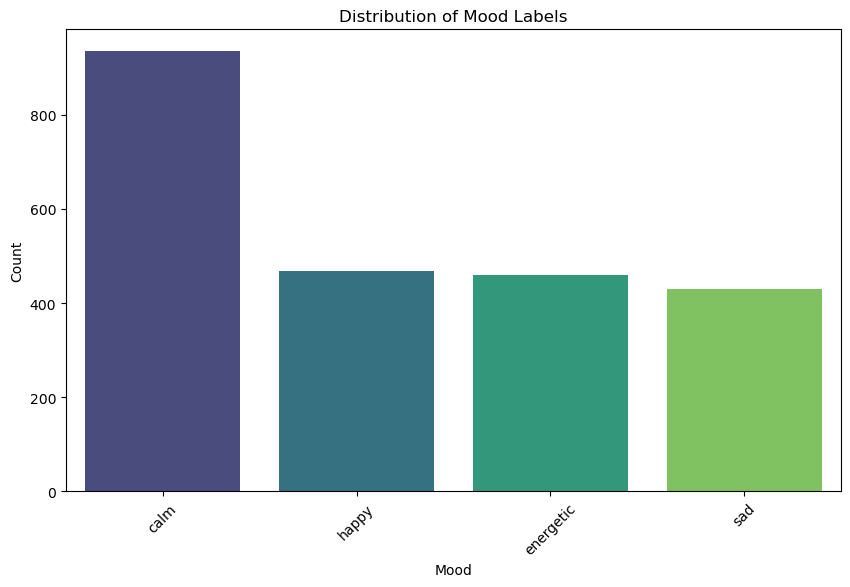

In [12]:
# Count the occurrences of each unique mood
mood_counts = df_moods['mood'].value_counts()
print(mood_counts)
# Plot the distribution of the 'mood' labels
plt.figure(figsize=(10, 6))  # You can adjust the size as needed
sns.barplot(x=mood_counts.index, y=mood_counts.values, palette='viridis')
plt.title('Distribution of Mood Labels')
plt.xlabel('Mood')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotates the labels on the x-axis for better readability
plt.show()

## 2. Pre-process our df_main for labeling

In [13]:
# Rename and reorder columns in df_moods_2 to match df_moods
df_main_cleaned = df_main.drop(columns=['artists_uris', 'playlist_uris', 'release_date', 'artists_genres', 'key', 'album_type', 'is_playable', 'analysis_url', 'artists_popularities', 'mode', 'popularity', 'artists_followers'], inplace=False)


df_main_cleaned.rename(columns={
    'track_uri': 'id',
    'duration_ms': 'length',
    'artists_names': 'artist' 
}, inplace=True)

df_main_cleaned['time_signature'] = df_main_cleaned['time_signature'].astype('Int64')
df_main_cleaned['length'] = df_main_cleaned['length'].astype('Int64')
df_main_cleaned.head()



,id,name,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,length,time_signature
0,spotify:track:3v6sBj3swihU8pXQQHhDZo,Way Up (feat. Ava Re),['Floduxe'],0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,195000,4
1,spotify:track:7KCWmFdw0TzoJbKtqRRzJO,Fantasy - Felix Jaehn Remix,"['Alina Baraz', 'Galimatias']",0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,194641,4
2,spotify:track:2CY92qejUrhyPUASawNVRr,Try Me,['DeJ Loaf'],0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,217573,4
3,spotify:track:11BPfwVbB7vok7KfjBeW4k,Walk on by (Sound Remedy Remix),['Noosa'],0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,443478,4
4,spotify:track:3yUJKPsjvThlcQWTS9ttYx,Pretty Wings,"['Zak Waters', 'Pretty Sister']",0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,225862,4


In [14]:
# Check if the all columns except mood match
# Get lists of columns
columns_df_moods = set(df_moods.columns)
columns_df_main_cleaned = set(df_main_cleaned.columns)

# Find common columns
common_columns = columns_df_moods.intersection(columns_df_main_cleaned)

# Find unique columns
unique_to_df_moods = columns_df_moods.difference(columns_df_main_cleaned)
unique_to_df_main_cleaned = columns_df_main_cleaned.difference(columns_df_moods)

# Print results
print("Common columns:", common_columns)
print("Columns unique to df_moods:", unique_to_df_moods)
print("Columns unique to df_main_cleaned:", unique_to_df_main_cleaned)

Common columns: {'name', 'id', 'danceability', 'liveness', 'artist', 'instrumentalness', 'length', 'speechiness', 'loudness', 'energy', 'time_signature', 'tempo', 'acousticness', 'valence'}
Columns unique to df_moods: {'mood'}
Columns unique to df_main_cleaned: set()


In [15]:
# Re-order the colummns in df_main_cleaned
new_column_order = ['name', 'artist', 'id', 'length', 'danceability', 'acousticness',
       'energy', 'instrumentalness', 'liveness', 'valence', 'loudness',
       'speechiness', 'tempo', 'time_signature']

df_main_cleaned = df_main_cleaned[new_column_order]

In [16]:
df_main_cleaned.head()

,name,artist,id,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,time_signature
0,Way Up (feat. Ava Re),['Floduxe'],spotify:track:3v6sBj3swihU8pXQQHhDZo,195000,0.611,0.0169,0.614,0.000794,0.7530,0.520,-8.815,0.0672,128.050,4
1,Fantasy - Felix Jaehn Remix,"['Alina Baraz', 'Galimatias']",spotify:track:7KCWmFdw0TzoJbKtqRRzJO,194641,0.638,0.0118,0.781,0.009530,0.3490,0.250,-6.848,0.0285,122.985,4
2,Try Me,['DeJ Loaf'],spotify:track:2CY92qejUrhyPUASawNVRr,217573,0.560,0.0071,0.810,0.000008,0.2410,0.247,-8.029,0.0872,170.044,4
3,Walk on by (Sound Remedy Remix),['Noosa'],spotify:track:11BPfwVbB7vok7KfjBeW4k,443478,0.525,0.0178,0.699,0.000088,0.0888,0.199,-4.571,0.0353,92.011,4
4,Pretty Wings,"['Zak Waters', 'Pretty Sister']",spotify:track:3yUJKPsjvThlcQWTS9ttYx,225862,0.367,0.3650,0.771,0.000001,0.0965,0.163,-5.863,0.1060,115.917,4


In [17]:
df_moods.head()

,name,artist,id,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,time_signature,mood
0,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,4,happy
1,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,4,sad
2,9 Crimes,Damien Rice,5GZEeowhvSieFDiR8fQ2im,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,4,sad
3,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,happy
4,A Boy Brushed Red Living In Black And White,Underoath,47IWLfIKOKhFnz1FUEUIkE,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,4,energetic


In [18]:
df_main_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277938 entries, 0 to 277937
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              277923 non-null  object 
 1   artist            277938 non-null  object 
 2   id                277938 non-null  object 
 3   length            277938 non-null  Int64  
 4   danceability      277938 non-null  float64
 5   acousticness      277938 non-null  float64
 6   energy            277938 non-null  float64
 7   instrumentalness  277938 non-null  float64
 8   liveness          277938 non-null  float64
 9   valence           277938 non-null  float64
 10  loudness          277938 non-null  float64
 11  speechiness       277938 non-null  float64
 12  tempo             277938 non-null  float64
 13  time_signature    277938 non-null  Int64  
dtypes: Int64(2), float64(9), object(3)
memory usage: 30.2+ MB


In [19]:
df_moods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2293 non-null   object 
 1   artist            2293 non-null   object 
 2   id                2293 non-null   object 
 3   length            2293 non-null   int64  
 4   danceability      2293 non-null   float64
 5   acousticness      2293 non-null   float64
 6   energy            2293 non-null   float64
 7   instrumentalness  2293 non-null   float64
 8   liveness          2293 non-null   float64
 9   valence           2293 non-null   float64
 10  loudness          2293 non-null   float64
 11  speechiness       2293 non-null   float64
 12  tempo             2293 non-null   float64
 13  time_signature    2293 non-null   int64  
 14  mood              2293 non-null   object 
dtypes: float64(9), int64(2), object(4)
memory usage: 268.8+ KB


### 2.1 PCA on df_main_cleaned

In [20]:
# Selecting numerical features
features = df_main_cleaned.select_dtypes(include=['float64', 'Int64'])

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [21]:
# Choosing the number of components for illustration
pca = PCA(n_components=0.95)  # Retain 95% of variance

# Fitting PCA on the scaled data
features_pca = pca.fit_transform(features_scaled)

# The result is a numpy array with reduced dimensionality
print("Original feature set shape:", features_scaled.shape)
print("Reduced feature set shape:", features_pca.shape)

Original feature set shape: (277938, 11)
Reduced feature set shape: (277938, 9)


In [22]:
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.32084273 0.11658756 0.10577181 0.09015564 0.08097073 0.07694418
 0.06739938 0.06409439 0.03943276]


## 3. Implementation of the classifiers

### 3.1 Training data preprocessing

In [23]:
X = df_moods.drop(columns=['name', 'artist', 'id', 'mood'], axis=1)
y = df_moods['mood']
X.head()

,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,time_signature
0,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,4
1,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,4
2,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,4
3,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4
4,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,4


In [24]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 3.13522114,  1.78862425, -0.78738041, ..., -0.02768227,
         0.07336351,  0.20273336],
       [ 2.12002465, -1.3900204 , -1.11610261, ..., -0.36772485,
         0.13057178,  0.20273336],
       [ 0.4267321 , -1.61940713,  1.37255544, ..., -0.57916951,
         0.65618101,  0.20273336],
       ...,
       [ 0.91072425, -0.24308676,  0.32320516, ...,  2.86948051,
         0.24994285,  0.20273336],
       [ 0.06251655, -1.11475633, -0.20286169, ..., -0.56804084,
         0.81165406,  0.20273336],
       [ 1.68349654, -0.24964067, -0.53687239, ..., -0.44315247,
         1.7671841 ,  0.20273336]])

In [25]:
# Encode the 'mood' labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [26]:
# COMMENT ALL THIS CELL OUT IF YOU DON'T WANT THIS
# Applying SMOTE to do oversampling and balance the dataset 
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)
# Decoding the labels back to original
y_resampled_decoded = label_encoder.inverse_transform(y_resampled)
# Convert it to a pandas Series
y_resampled_series = pd.Series(y_resampled_decoded)
# Print the distribution of the resampled labels
print(y_resampled_series.value_counts())

happy        935
sad          935
energetic    935
calm         935
dtype: int64


In [27]:
# Split the dataset into training (80%) and testing (20%) sets with oversampling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Split the dataset into training (80%) and testing (20%) sets without oversampling
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

### 3.2 Random Forest

In [28]:
# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict the moods on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print out the accuracy and detailed classification report
print(f'Accuracy: {accuracy*100:.2f}%')
print('Classification Report:')
print(classification_rep)

Accuracy: 78.48%
Classification Report:
              precision    recall  f1-score   support

        calm       0.89      0.82      0.86       180
   energetic       0.75      0.81      0.77       190
       happy       0.72      0.69      0.71       177
         sad       0.79      0.81      0.80       201

    accuracy                           0.78       748
   macro avg       0.79      0.78      0.78       748
weighted avg       0.79      0.78      0.79       748



### 3.2.1 RF Hyperparameter Tunning

In [29]:
# # Hyperparameter tunning
# # Define the hyperparameter grid to search
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
#     'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
#     'criterion': ['gini', 'entropy']  # The function to measure the quality of a split
# }

# # Initialize the Random Forest classifier
# rf = RandomForestClassifier(random_state=42)

# # Initialize the GridSearchCV object
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)


In [30]:
# best_params = grid_search.best_params_
# print("Best hyperparameters:", best_params)
# best_rf_model = RandomForestClassifier(**best_params, random_state=42)

# # Perform cross-validation and then calculate the mean and standard deviation of the cross-validation scores
# cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5)

# print("Cross-validation scores:", cv_scores)
# print("Mean CV score:", cv_scores.mean())
# print("Standard deviation in CV scores:", cv_scores.std())

In [31]:
# # Retrieve the best estimator found by RandomizedSearchCV
# best_rf = rnd_search_rf.best_estimator_

# # Perform cross-validation and print each fold score
# cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5)

# print("Cross-validation scores:", cv_scores)
# print("Mean CV Score:", cv_scores.mean())

### 3.3. Logistic Regression


In [32]:
# # Initialize the Logistic Regression model
# log_reg = LogisticRegression(max_iter=10000, random_state=42)

# # Train the model
# log_reg.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = log_reg.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy*100:.2f}%")

# # Detailed classification report
# print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [33]:
# # Hyperparameter Tunning

# # Define the parameter grid
# param_grid_lr = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2']
# }

# # Initialize the classifier
# lr_hyperparameter = LogisticRegression(random_state=42, solver='liblinear') # solver must support the penalty

# # Initialize the GridSearchCV object
# grid_search_lr = GridSearchCV(estimator=lr_hyperparameter, param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search_lr.fit(X_train, y_train)

# # Best parameters
# print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

In [34]:
# # Initialize the Logistic Regression model with the best hyperparameters
# log_reg = LogisticRegression(C=100, penalty='l1', max_iter=1000, random_state=42, solver='liblinear')

# # Train the model
# log_reg.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = log_reg.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy*100:.2f}%")

# # Detailed classification report
# print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

### 3.4. SVM

In [35]:
# # Initialize the SVM model
# svm_model = SVC(kernel='linear', random_state=42)

# # Train the model on the training dataset
# svm_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = svm_model.predict(X_test)

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy*100:.2f}%")

# # Generate a classification report
# print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [36]:
# # Define the revised parameter grid
# param_grid_svm = {
#     'C': [1, 10],  # Removed 0.1 to focus on potentially higher-margin separators
#     'kernel': ['rbf', 'poly'],  # Focused on the two kernels that offer non-linear decision boundaries
#     'gamma': ['scale']  # Using 'scale' as it's generally a good default
# }

# # Everything else remains the same
# svm_hyperparameter = SVC(random_state=42)
# grid_search_svm = GridSearchCV(estimator=svm_hyperparameter, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2)
# grid_search_svm.fit(X_train, y_train)
# print("Best parameters for SVM:", grid_search_svm.best_params_)

In [37]:
# # Initialize the SVM model with the best hyperparameters
# svm_model = SVC(C=10, gamma='scale', kernel='rbf', random_state=42)

# # Train the model on the training dataset
# svm_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = svm_model.predict(X_test)

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy*100:.2f}%")

# # Generate a classification report
# print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

### 3.5. XGBoost

In [38]:
# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred = xgb_clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 79.01%
              precision    recall  f1-score   support

        calm       0.88      0.82      0.85       180
   energetic       0.76      0.78      0.77       190
       happy       0.73      0.73      0.73       177
         sad       0.80      0.83      0.81       201

    accuracy                           0.79       748
   macro avg       0.79      0.79      0.79       748
weighted avg       0.79      0.79      0.79       748



In [39]:
# # Parameter grid for XGBoost
# params = {
#     'n_estimators': np.arange(50, 400, 50),
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': np.arange(3, 10, 2),
#     'colsample_bytree': [0.3, 0.7, 1],
#     'gamma': [0, 0.1, 0.2, 0.5]
# }

# # Initialize the XGBoost classifier
# xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# # Initialize RandomizedSearchCV
# rnd_search_xgb = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)

# # Fit RandomizedSearchCV
# rnd_search_xgb.fit(X_train, y_train)

# # Best parameters and score
# print("Best parameters found: ", rnd_search_xgb.best_params_)
# print("Best score: ", rnd_search_xgb.best_score_)


In [40]:
# # Predictions with the tuned model
# best_xgb = rnd_search_xgb.best_estimator_
# y_pred_tuned = best_xgb.predict(X_test)

# # Evaluation
# accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
# print(f"Accuracy of the tuned model: {accuracy_tuned*100:.2f}%")
# print(classification_report(y_test, y_pred_tuned, target_names=label_encoder.classes_))

In [41]:
# # Generate the confusion matrix for the tuned XGBoost model predictions
# cm = confusion_matrix(y_test, y_pred_tuned)

# # Plotting the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix for XGBoost Classifier')
# plt.show()

## 4. Label the our large dataset with our best classifier

With oversampling the best models are XGBoost and Random Forest

In [42]:
X_df1 = df_main_cleaned.drop(columns=['name', 'artist', 'id'])
# Feature scaling
scaler = StandardScaler()
X_df1_scaled = scaler.fit_transform(X_df1)
X_df1_scaled.shape

(277938, 11)

### 4.1 Best Random Forest Classifier with unbalanced dataset

NOTE: Please uncomment the cell below if you are NOT using oversampling

In [43]:
# best_params = {
#     'bootstrap': True,
#     'criterion': 'gini',
#     'max_depth': None,
#     'min_samples_leaf': 2,
#     'min_samples_split': 2,
#     'n_estimators': 100
# }

# # Instantiate the model with the best parameters
# best_rf_model = RandomForestClassifier(**best_params, random_state=42)

# # Assuming X_train and y_train are your full training dataset and labels
# best_rf_model.fit(X_train, y_train)

### 4.2 Best Random Forest Classifier with balanced dataset

NOTE: Please comment the cell below if you are NOT using oversampling

Accuracy: 80.21%
Classification Report:
              precision    recall  f1-score   support

        calm       0.88      0.82      0.85       180
   energetic       0.79      0.81      0.80       190
       happy       0.75      0.75      0.75       177
         sad       0.80      0.83      0.81       201

    accuracy                           0.80       748
   macro avg       0.80      0.80      0.80       748
weighted avg       0.80      0.80      0.80       748



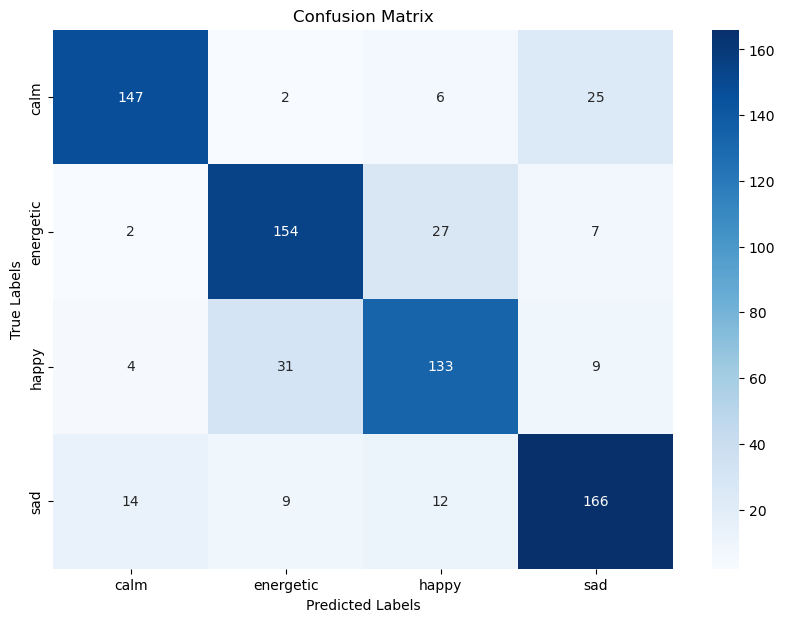

In [44]:
# Initialize and train the Random Forest classifier with specified hyperparameters
rf_classifier = RandomForestClassifier(
    bootstrap=False,
    criterion='entropy',
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)
rf_classifier.fit(X_train, y_train)

# Predict the moods on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print out the accuracy and detailed classification report
print(f'Accuracy: {accuracy*100:.2f}%')
print('Classification Report:')
print(classification_rep)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 4.3 Best XGBoost with oversampling

Accuracy: 81.15%
              precision    recall  f1-score   support

        calm       0.90      0.83      0.86       180
   energetic       0.78      0.81      0.80       190
       happy       0.75      0.76      0.75       177
         sad       0.82      0.85      0.83       201

    accuracy                           0.81       748
   macro avg       0.81      0.81      0.81       748
weighted avg       0.81      0.81      0.81       748



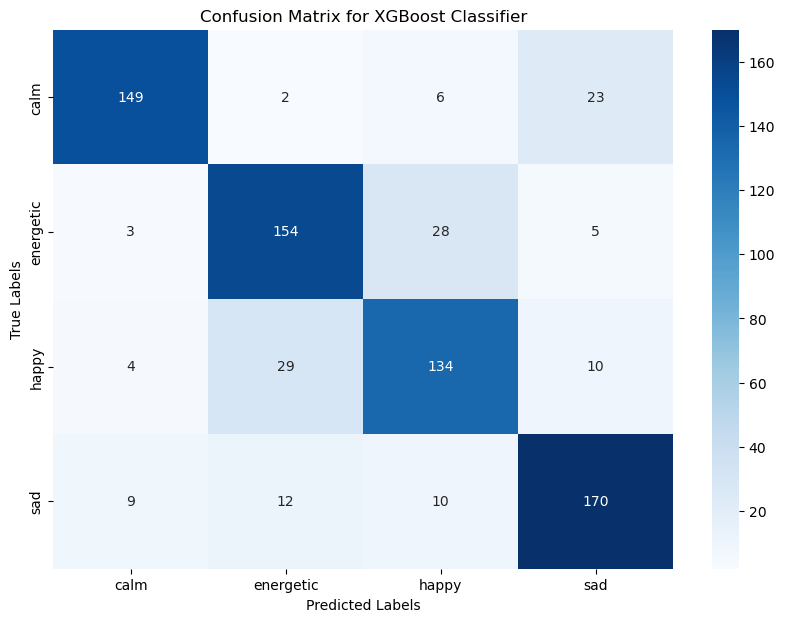

In [45]:
# Initialize the XGBoost classifier with specified hyperparameters
xgb_clf = XGBClassifier(
    n_estimators=150,
    max_depth=9,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=0.7,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred = xgb_clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()

### 4.3 Labeling the Dataset

In [46]:
# Predicting moods (use xgb_clf for XGBoost / use rf_classifier for RF)
predicted_moods = xgb_clf.predict(X_df1_scaled) 
# Assuming your predictions are stored in `predicted_moods`
predicted_moods = label_encoder.inverse_transform(predicted_moods)

# Adding the predicted moods to your DataFrame
df_main['predicted_mood'] = predicted_moods

In [47]:
# Output the first few rows to verify
df_main_sorted_by_popularity = df_main.sort_values(by=['popularity'], ascending=False)
# df_main_sorted_by_popularity.info()
df_main_sorted_by_popularity[['name','popularity', 'artists_names','predicted_mood']].head(50)

,name,popularity,artists_names,predicted_mood
261193,Flowers,100,['Miley Cyrus'],calm
226293,"Shakira: Bzrp Music Sessions, Vol. 53",96,"['Bizarrap', 'Shakira']",sad
138524,TQG,96,['KAROL G'],calm
274024,Boy's a liar Pt. 2,96,"['PinkPantheress', 'Ice Spice']",happy
269682,Die For You - Remix,95,"['The Weeknd', 'Ariana Grande']",sad
260639,Calm Down (with Selena Gomez),94,"['Rema', 'Selena Gomez']",energetic
266216,I'm Good (Blue),94,"['David Guetta', 'Bebe Rexha']",energetic
269098,Here With Me,93,['d4vd'],sad
109517,Anti-Hero,93,['Taylor Swift'],sad
193140,La Bachata,93,['Manuel Turizo'],calm


In [48]:
df_main_sorted_by_popularity.to_csv('DATA/labeled_main_dataset.csv', index=False)